In [8]:
# Dataset
import torch
import os
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy as sp
train_dir = Path(r'C:\Users\sebas\Documents\MATLAB\DataProCiencia\DeepLearning\train')


# Final version of dataset

In [9]:
class CustomDataset(Dataset):
    def __init__(self, data_folder):
        data_folder = Path(data_folder)
        self.input_folder = data_folder/'input'
        self.output_folder = data_folder/'output'
        self.data_file_list = sorted(os.listdir(self.input_folder))

    def __len__(self):
        return len(self.data_file_list)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_folder, self.data_file_list[idx])
        output_path = os.path.join(self.output_folder, self.data_file_list[idx])
        sld = np.load(input_path)
        att_ideal = np.load(output_path)

        return torch.Tensor(sld), torch.Tensor(att_ideal).unsqueeze(0)

In [10]:
from torch.utils.data import DataLoader

dataset = CustomDataset(train_dir)
dataloader = DataLoader(dataset=dataset, batch_size=6, shuffle=True)

x,y = next(iter(dataloader))
len(dataloader)

1

Mean: -32.16627883911133, std: 14.401968002319336


[]

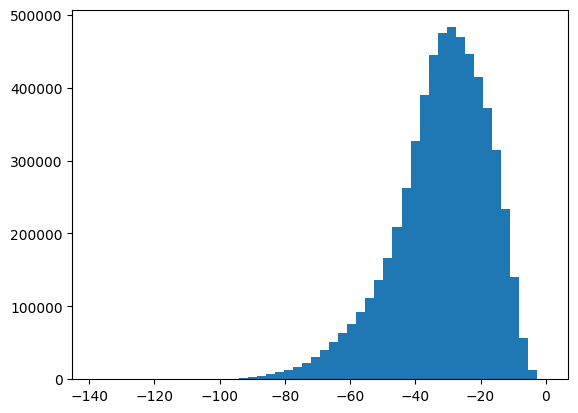

In [11]:
data_vec = x.numpy().flatten()
print(f"Mean: {data_vec.mean()}, std: {data_vec.std()}")
plt.hist(data_vec,50)
plt.plot()

In [24]:
from torchvision import transforms
class CustomDataset(Dataset):
    def __init__(self, data_folder):
        data_folder = Path(data_folder)
        self.input_folder = data_folder/'input'
        self.output_folder = data_folder/'output'
        self.data_file_list = sorted(os.listdir(self.input_folder))

    def __len__(self):
        return len(self.data_file_list)

    def __getitem__(self, idx):
        input_path = os.path.join(self.input_folder, self.data_file_list[idx])
        output_path = os.path.join(self.output_folder, self.data_file_list[idx])
        sld = np.load(input_path)
        att_ideal = np.expand_dims(np.load(output_path),axis=0)

        input_transforms = transforms.Compose([
            torch.Tensor,
            transforms.Normalize(-40,40),
        ])

        output_transforms = transforms.Compose([
            torch.Tensor,
            transforms.Normalize(1,1)
        ])

        x = input_transforms(sld)
        y = output_transforms(att_ideal)

        return x,y

In [25]:
from torch.utils.data import DataLoader

dataset = CustomDataset(train_dir)
dataloader = DataLoader(dataset=dataset, batch_size=6, shuffle=True)

x,y = next(iter(dataloader))

Mean: 0.19584301114082336, std: 0.36004918813705444


[]

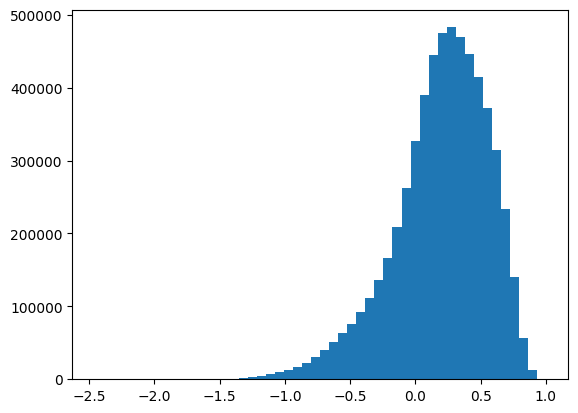

In [26]:
data_vec = x.numpy().flatten()
print(f"Mean: {data_vec.mean()}, std: {data_vec.std()}")
plt.hist(data_vec,50)
plt.plot()

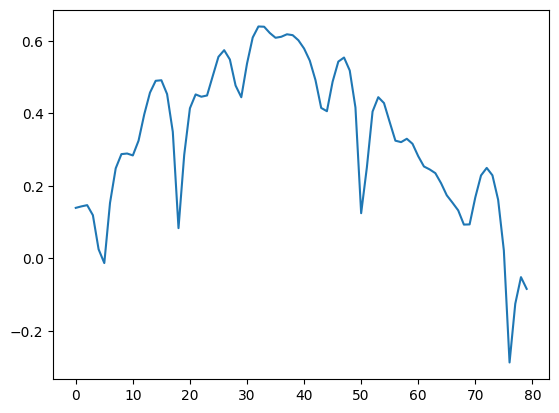

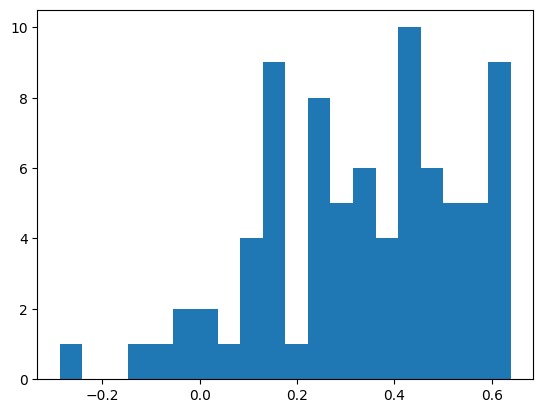

In [27]:
data_pixel = x[0,:,30,30].numpy().flatten()
plt.plot(data_pixel)
plt.show()

plt.hist(data_pixel, 20)
plt.show()

In [28]:
y[0,:,30,30].numpy().flatten()

array([-0.25], dtype=float32)

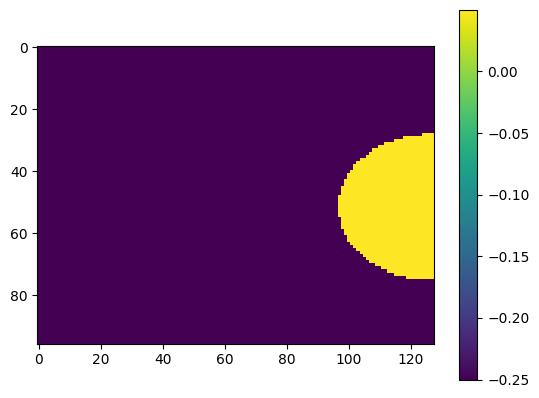

In [29]:
plt.imshow(y[0,0,:,:])
plt.colorbar()
plt.show()

In [17]:
print(data_pixel.mean())
print(data_pixel.std())

0.12550916
0.8523868


# Arquitecture

In [30]:
import math
import torch
import torch.nn as nn
from modules.nn import *

# PositionalEncoding Source： https://github.com/lmnt-com/wavegrad/blob/master/src/wavegrad/model.py
class PositionalEncoding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, noise_level):
        count = self.dim // 2
        step = torch.arange(count, dtype=noise_level.dtype, device=noise_level.device) / count
        encoding = noise_level.unsqueeze(1) * torch.exp(-math.log(1e4) * step.unsqueeze(0))
        encoding = torch.cat([torch.sin(encoding), torch.cos(encoding)], dim=-1)
        return encoding


class ResBlock(nn.Module):
    """
    A residual block that can optionally change the number of channels.

    :param channels: the number of input channels.
    :param emb_channels: the number of timestep embedding channels.
    :param dropout: the rate of dropout.
    :param out_channels: if specified, the number of out channels.
    :param use_conv: if True and out_channels is specified, use a spatial
        convolution instead of a smaller 1x1 convolution to change the
        channels in the skip connection.
    :param dims: determines if the signal is 1D, 2D, or 3D.
    :param use_checkpoint: if True, use gradient checkpointing on this module.
    """

    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        dims=2,
        use_checkpoint=False,
        residual = True,
        group_norm = True
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels
        self.use_conv = use_conv
        self.residual = residual
        self.use_checkpoint = use_checkpoint
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            normalization(channels, group_norm),
            SiLU(),
            conv_nd(dims, channels, self.out_channels, 3, padding=1),
        )
        self.emb_layers = nn.Sequential(
            SiLU(),
            linear(
                emb_channels,
                2 * self.out_channels if use_scale_shift_norm else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            normalization(self.out_channels, group_norm),
            SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                conv_nd(dims, self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if residual:
            if self.out_channels == channels:
                self.skip_connection = nn.Identity()
            elif use_conv:
                self.skip_connection = conv_nd(
                    dims, channels, self.out_channels, 3, padding=1
                )
            else:
                self.skip_connection = conv_nd(dims, channels, self.out_channels, 1)
        else:
            self.skip_connection = None

    def forward(self, x, emb):
        """
        Apply the block to a Tensor, conditioned on a timestep embedding.

        :param x: an [N x C x ...] Tensor of features.
        :param emb: an [N x emb_channels] Tensor of timestep embeddings.
        :return: an [N x C x ...] Tensor of outputs.
        """
        return checkpoint(
            self._forward, (x, emb), self.parameters(), self.use_checkpoint
        )

    def _forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = th.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)
        if self.residual:
            h = self.skip_connection(x) + h
        return h


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.

    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(self, channels, num_heads=1, use_checkpoint=False):
        super().__init__()
        self.channels = channels
        self.num_heads = num_heads
        self.use_checkpoint = use_checkpoint

        self.norm = normalization(channels)
        self.qkv = conv_nd(1, channels, channels * 3, 1)
        self.attention = QKVAttention()
        self.proj_out = zero_module(conv_nd(1, channels, channels, 1))

    def forward(self, x):
        return checkpoint(self._forward, (x,), self.parameters(), self.use_checkpoint)

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        qkv = qkv.reshape(b * self.num_heads, -1, qkv.shape[2])
        h = self.attention(qkv)
        h = h.reshape(b, -1, h.shape[-1])
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class QKVAttention(nn.Module):
    """
    A module which performs QKV attention.
    """

    def forward(self, qkv):
        """
        Apply QKV attention.

        :param qkv: an [N x (C * 3) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x C x T] tensor after attention.
        """
        ch = qkv.shape[1] // 3
        q, k, v = th.split(qkv, ch, dim=1)
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = th.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = th.softmax(weight.float(), dim=-1).type(weight.dtype)
        return th.einsum("bts,bcs->bct", weight, v)

In [31]:
class UNETv1(nn.Module):
    def __init__(
            self, 
            in_channels=3, 
            out_channels=1, 
            features=[64, 128, 256, 512], 
            emb_dim = 256,
            residual = True,
            attention_heads = 4,
            attention_res = [256,512],
            group_norm = True,
        ):
        super(UNETv1, self).__init__()

        self.time_mlp = nn.Sequential(
            PositionalEncoding(features[0]),
            linear(features[0], emb_dim),
            SiLU(),
            linear(emb_dim, emb_dim),
        )

        # Initial convolutional layers
        self.initial_conv_x = conv_nd(2, in_channels, features[0], 1)
        self.initial_block_x = ResBlock(
            channels = features[0],
            emb_channels = emb_dim,
            dropout = 0,
            out_channels = features[0],
            use_conv = False,
            use_scale_shift_norm = True,
            dims = 2,
            use_checkpoint = False,
            residual=residual,
            group_norm=group_norm
        )

        self.initial_conv_y = conv_nd(2, out_channels, features[0], 1)
        self.initial_block_y = ResBlock(
            channels = features[0],
            emb_channels = emb_dim,
            dropout = 0,
            out_channels = features[0],
            use_conv = False,
            use_scale_shift_norm = True,
            dims = 2,
            use_checkpoint = False,
            residual=residual,
            group_norm=group_norm
        )

        # Down part of UNET
        self.downBlocks = nn.ModuleList()
        self.downAttention = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        for feature in features:
            self.downBlocks.append(
                ResBlock(
                    channels = feature,
                    emb_channels = emb_dim,
                    dropout = 0,
                    out_channels = feature*2,
                    use_conv = False,
                    use_scale_shift_norm = True,
                    dims = 2,
                    use_checkpoint = False,
                    residual=residual,
                    group_norm=group_norm
                ))
            if feature in attention_res:
                self.downAttention.append(AttentionBlock(
                    feature*2, use_checkpoint=False, num_heads=attention_heads
                ))
            else:
                self.downAttention.append(nn.Identity())                

        # Up part of UNET
        self.upBlocks = nn.ModuleList()
        self.upConvs = nn.ModuleList()
        self.upAttention = nn.ModuleList()
        for feature in reversed(features):
            self.upConvs.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.upBlocks.append(
                ResBlock(
                    channels = feature * 2,
                    emb_channels = emb_dim,
                    dropout = 0,
                    out_channels = feature,
                    use_conv = False,
                    use_scale_shift_norm = True,
                    dims = 2,
                    use_checkpoint = False,
                    residual=residual,
                    group_norm=group_norm
                ))
            if feature in attention_res:
                self.upAttention.append(AttentionBlock(
                    feature, use_checkpoint=False, num_heads=attention_heads
                ))
            else:
                self.upAttention.append(nn.Identity())


        self.final_block = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x, y, t):
        # x: IQ image
        # y: Noisy Bmode
        time_emb = self.time_mlp(t)

        x = self.initial_conv_x(x)
        x = self.initial_block_x(x, time_emb)
        y = self.initial_conv_y(y)
        x = x + self.initial_block_y(y, time_emb)

        # Convolutional layers and max-pooling
        skip_connections = []
        for idx in range(len(self.downBlocks)):
            skip_connections.append(x)
            x = self.pool(x)
            x = self.downBlocks[idx](x, time_emb)
            x = self.downAttention[idx](x)

        # Convolutional layers and up-sampling
        skip_connections = skip_connections[::-1]  # Reversing list
        for idx in range(len(self.upBlocks)):
            x = self.upConvs[idx](x)  # UpConvolution
            concat_skip = torch.cat((skip_connections[idx], x), dim=1)
            x = self.upBlocks[idx](concat_skip, time_emb)  # Double convs
            x = self.upAttention[idx](x)

        return self.final_block(x)


In [27]:
model = UNETv1(in_channels=80, residual=False, attention_res=[])

In [29]:
t = torch.randint(0, 100, (x.shape[0],))
noise = torch.randn_like(y)
y_pred = model(x,y,t)

torch.Size([6, 1, 96, 128])